# **Análisis de Severidad KPPS: Configuración Inicial**

Para evaluar la carga de dolor en los pacientes de la cohorte ReMePARK, necesitamos acceder a los datos que limpiamos y unificamos previamente. Este script comienza estableciendo el puente entre el entorno de procesamiento (Colab) y el almacenamiento en la nube.

# **Montaje de la Unidad (Google Drive)**
El siguiente comando importa la librería del sistema y solicita los permisos necesarios para leer y escribir archivos en tu Google Drive personal.

In [ ]:
from google.colab import drive

# Monta la unidad de Google Drive en el directorio local /content/drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Importación de Librerías y Dependencias**

Para llevar a cabo el cálculo de los dominios de severidad de la escala KPPS y su posterior visualización, necesitamos cargar un conjunto de herramientas estándar en análisis de datos.

**Carga de Módulos**

Ejecutamos la importación de los siguientes paquetes:

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

**Desglose de herramientas:**

**Manipulación de Datos (pandas, numpy):** Serán el motor principal. pandas nos permitirá manejar la base de datos como un DataFrame estructurado, mientras que numpy nos ayudará a realizar sumas vectorizadas para calcular los puntajes totales de cada dominio.

**Visualización (matplotlib, seaborn):** Indispensables para esta etapa. Una vez calculada la severidad, usaremos estas librerías para crear gráficos de caja (boxplots) que nos permitan comparar qué dominios de dolor son más intensos en la población.

**Gestión de Archivos (os, glob):** Útiles para navegar en las carpetas de Drive y gestionar rutas de archivos de manera robusta.

**Expresiones Regulares (re):** Muy útil si necesitamos buscar patrones específicos en los nombres de las columnas (por ejemplo, identificar todas las columnas que empiecen por "KPSS_" o "KPPS_").

# **Carga del Dataset Pre-procesado**

Para realizar el cálculo de severidad, partimos de la base de datos que ya ha sido limpiada y filtrada previamente. Esto garantiza que trabajamos con una cohorte válida y que los cálculos no se verán afectados por filas vacías o inconsistentes.

**Lectura del Archivo**

Definimos la ruta al archivo Remepark_cleaned_kpss.xlsx y lo cargamos en memoria.





In [ ]:
# 1. Definir ruta del archivo fuente
# Nota: Asegurarse de que esta ruta apunte al archivo generado en la fase de limpieza
file_path = '/content/drive/MyDrive/LCEN/08_Bases de Datos y Herramientas/08.2_ReMePARK/08.2.6_Unified ReMePARK 2024/Notebooks/Remepark_cleaned_kpss.xlsx'

# 2. Cargar archivo Excel en un DataFrame
df = pd.read_excel(file_path)

# 3. Visualizar las primeras 5 filas para verificar la carga correcta
df.head()

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
0,4170,2022,5/17/2022,1,1,100000,0,0,0,0,...,34.375,42.5,25.000000,33.333333,0.00,0.0,12.50,25.0,33.333333,21.458333
1,4475,2022,4/27/2022,1,1,100208,1,1,1,1,...,15.625,10.0,25.000000,12.500000,0.00,0.0,25.00,25.0,8.333333,13.229167
2,3509,2020,2020-06-02 00:00:00,1,1,100235,0,0,0,0,...,9.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4537,2023,8/14/2023,10,9,104248,1,1,1,1,...,31.250,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12 00:00:00,10,10,104248,1,0,0,0,...,25.000,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167


# **Filtrado de Registros por Visitas Acumuladas**

Para centrar el análisis en el seguimiento o en pacientes con historial previo, aplicamos un filtro para excluir las filas correspondientes a la primera visita registrada (o aquellas con un contador acumulado igual a 1).

**Exclusión de Registros Iniciales**

El siguiente código genera un nuevo DataFrame (df_filtered) conservando únicamente las filas donde la variable accum.visits_kpps es mayor estrictamente a 1.

In [ ]:
# 1. Aplicación del filtro numérico
# Se seleccionan las filas donde el acumulado de visitas es mayor a 1
# .copy() se usa para asegurar que 'df_filtered' sea un objeto independiente y no una vista
df_filtered = df[df['accum.visits_kpps'] > 1].copy()

# 2. Verificación del resultado
# Mostramos las primeras filas para confirmar que los valores de 'accum.visits_kpps' comienzan en 2 o más
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
3,4537,2023,8/14/2023,10,9,104248,1,1,1,1,...,31.25,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12 00:00:00,10,10,104248,1,0,0,0,...,25.00,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167
5,4362,2022,2022-03-03 00:00:00,3,2,113193,2,2,4,4,...,18.75,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250
6,4363,2024,2/15/2024,3,3,113193,1,1,1,1,...,31.25,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667
7,4555,2021,10/18/2021,3,2,129131,0,0,0,0,...,6.25,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500


# **Estandarización Temporal: Conversión a Datetime**

Para realizar cálculos de intervalos temporales (tiempo transcurrido entre visitas), es obligatorio asegurarse de que la variable de fecha tenga el formato correcto. A menudo, al importar desde Excel, las fechas se leen como texto (object), lo que impide realizar operaciones aritméticas con ellas.

**Transformación de Tipos de Datos**

El siguiente código convierte la columna fecha.eval_kpps al formato estándar de fecha de Pandas (datetime64).


In [ ]:
# 1. Conversión a objeto Datetime
# Utilizamos 'pd.to_datetime' para interpretar las cadenas de texto como fechas.
# errors='coerce': Si encuentra una fecha inválida (ej. "sin fecha"), la convierte en NaT (Not a Time) en lugar de romper el código.
df_filtered['fecha.eval_kpps'] = pd.to_datetime(df_filtered['fecha.eval_kpps'], errors='coerce')

# 2. Verificación de Tipos
# .info() nos permite auditar si la columna cambió exitosamente de 'object' a 'datetime64[ns]'
display(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 3 to 1049
Columns: 312 entries, Consecutivo to PDQ39.SI.index
dtypes: datetime64[ns](2), float64(186), int64(114), object(10)
memory usage: 2.1+ MB


None

**Por qué es importante este paso:**

**Aritmética de Fechas:** Solo con el formato datetime podemos ejecutar operaciones como Fecha_Visita_2 - Fecha_Visita_1.

**Manejo de Errores (coerce):** Bases de datos clínicas reales suelen tener errores de tipeo. Este parámetro asegura que esos errores se gestionen como valores nulos (NaT) de forma segura, permitiendo identificarlos y filtrarlos si es necesario.

# **Ordenamiento Cronológico y por Sujeto**

Antes de calcular intervalos de tiempo entre visitas, es imprescindible organizar la estructura de los datos. Necesitamos que las filas estén agrupadas por paciente y, dentro de cada paciente, ordenadas de la visita más antigua a la más reciente.

**Algoritmo de Ordenamiento**

El siguiente código utiliza sort_values para reorganizar el DataFrame basándose en dos claves jerárquicas:

**reg.innn (Prioridad 1):** Agrupa todas las filas de un mismo paciente.

**fecha.eval_kpps (Prioridad 2):** Ordena las visitas cronológicamente dentro de cada bloque de paciente.


**Reasoning**:
Sort the dataframe by subject ID and then by date to prepare for calculating time differences between consecutive visits.



In [ ]:
# 1. Ejecución del ordenamiento
# ascending=[True, True] asegura un orden ascendente (A-Z, Antiguo-Reciente) para ambas columnas.
df_filtered = df_filtered.sort_values(by=['reg.innn', 'fecha.eval_kpps'], ascending=[True, True])

# 2. Verificación visual
# Al mostrar el head(), deberíamos ver al mismo sujeto repetido en filas consecutivas
# con sus fechas avanzando progresivamente.
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
3,4537,2023,2023-08-14,10,9,104248,1,1,1,1,...,31.25,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833
4,4538,2024,2024-02-12,10,10,104248,1,0,0,0,...,25.00,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167
5,4362,2022,2022-03-03,3,2,113193,2,2,4,4,...,18.75,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250
6,4363,2024,2024-02-15,3,3,113193,1,1,1,1,...,31.25,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667
7,4555,2021,2021-10-18,3,2,129131,0,0,0,0,...,6.25,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500


**Por qué es crucial:**

Si los datos no están ordenados, al usar funciones de desplazamiento (como .shift() en el siguiente paso), podríamos estar restando la fecha de la Visita 1 del Paciente B menos la Visita 5 del Paciente A, generando datos de tiempo negativos o absurdos ("basura lógica").

# **Cálculo de Intervalos Temporales (Time Delta)**

Una vez que los datos están ordenados cronológicamente por sujeto, podemos calcular el tiempo exacto que ha transcurrido entre una visita y la siguiente. Esto es fundamental para determinar la frecuencia de seguimiento y validar si los intervalos entre evaluaciones son consistentes.

**Ejecución del Cálculo Diferencial**

El siguiente código agrupa los datos por paciente y aplica la función de diferenciación sobre la columna de fechas.

In [ ]:
# 1. Cálculo de la diferencia (Delta T)
# groupby('reg.innn'): Aísla el historial de cada paciente para que el cálculo no mezcle sujetos.
# .diff(): Resta el valor de la fila actual menos el valor de la fila anterior (Visit_N - Visit_N-1).
df_filtered['time_difference'] = df_filtered.groupby('reg.innn')['fecha.eval_kpps'].diff()

# 2. Verificación de resultados
display(df_filtered.head())

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
3,4537,2023,2023-08-14,10,9,104248,1,1,1,1,...,37.5,29.166667,41.666667,31.25,50.0,31.25,50.0,33.333333,38.020833,NaT
4,4538,2024,2024-02-12,10,10,104248,1,0,0,0,...,80.0,62.500000,8.333333,18.75,0.0,6.25,0.0,0.000000,21.979167,182 days
5,4362,2022,2022-03-03,3,2,113193,2,2,4,4,...,7.5,0.000000,25.000000,0.00,0.0,18.75,0.0,25.000000,9.531250,NaT
6,4363,2024,2024-02-15,3,3,113193,1,1,1,1,...,30.0,12.500000,25.000000,18.75,0.0,18.75,0.0,33.333333,17.291667,714 days
7,4555,2021,2021-10-18,3,2,129131,0,0,0,0,...,22.5,12.500000,0.000000,0.00,0.0,12.50,0.0,0.000000,5.937500,NaT


**Análisis de la Lógica:**

Aislamiento por groupby: Es crítico. Si no agrupamos por reg.innn, al terminar las visitas del Paciente A y empezar las del Paciente B, el código restaría la fecha de B menos la de A, generando un dato erróneo. El agrupamiento asegura que el cálculo se reinicie para cada nuevo paciente.

**Resultado NaN (NaT):**

Para la primera visita de cada paciente, el resultado será NaT (Not a Time) o nulo.

Esto es correcto y esperado, ya que no existe una "visita previa" contra la cual restar.

**Tipo de Dato:** La nueva columna time_difference será de tipo timedelta64 (ej. 365 days 00:00:00), lo cual permite extraer fácilmente los días, meses o años posteriormente.

# **Análisis Descriptivo de Intervalos Temporales**

Una vez calculada la diferencia de tiempo entre visitas consecutivas para cada paciente, es necesario resumir esta información. Esto nos permite entender la estructura temporal de la cohorte: ¿Cada cuánto se evalúa a los pacientes en promedio? ¿Existe una gran variabilidad en los tiempos de seguimiento?

**Generación de Estadísticas de Tiempo**

El siguiente código utiliza el método .describe() sobre la columna de diferencias temporales (timedelta). Pandas es lo suficientemente inteligente para adaptar las estadísticas a unidades de tiempo (días).

In [ ]:
# 1. Cálculo de estadísticas descriptivas
# Al ser una columna de tipo 'timedelta', .describe() nos devolverá:
# count (N intervalos), mean (promedio de días), std, min, max y cuartiles.
time_difference_stats = df_filtered['time_difference'].describe()

# 2. Visualización de resultados
display(time_difference_stats)

,time_difference
count,502
mean,498 days 18:53:04.063745016
std,366 days 03:10:13.005101700
min,4 days 00:00:00
25%,225 days 00:00:00
50%,393 days 00:00:00
75%,697 days 12:00:00
max,1855 days 00:00:00


# **Análisis Longitudinal: Definición de Baseline y Endpoint**

Para evaluar la progresión de la severidad del dolor (KPSS.TOTAL), comparamos el estado inicial del paciente contra su última evaluación disponible. Este enfoque nos permite calcular el cambio neto a lo largo del periodo de seguimiento.

**Selección de Puntos de Corte Temporal**

Dado que los datos ya fueron ordenados cronológicamente en el paso anterior, podemos extraer fácilmente la primera y la última fila de cada paciente para crear dos sub-cohortes: "Inicio" y "Final".

In [ ]:
# 1. Extracción de la Visita Basal (Baseline / T0)
# Agrupamos por paciente y tomamos el primer registro cronológico.
# .reset_index() es vital para recuperar 'reg.innn' como columna y no como índice.
df_first_visit = df_filtered.groupby('reg.innn').first().reset_index()

# 2. Extracción de la Visita Final (Endpoint / Tn)
# Tomamos el último registro disponible para cada sujeto.
df_last_visit = df_filtered.groupby('reg.innn').last().reset_index()

# 3. Verificación de las Sub-cohortes
print("--- Visitas Basales (Muestra) ---")
display(df_first_visit.head())

print("\n--- Visitas Finales (Muestra) ---")
display(df_last_visit.head())

,reg.innn,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
0,104248,4537,2023,2023-08-14,10,9,1,1,1,1,...,37.5,29.166667,41.666667,31.25,50.0,31.25,50.000000,33.333333,38.020833,182 days
1,113193,4362,2022,2022-03-03,3,2,2,2,4,4,...,7.5,0.000000,25.000000,0.00,0.0,18.75,0.000000,25.000000,9.531250,714 days
2,129131,4555,2021,2021-10-18,3,2,0,0,0,0,...,22.5,12.500000,0.000000,0.00,0.0,12.50,0.000000,0.000000,5.937500,791 days
3,133232,1756,2019,2019-02-14,8,7,0,0,0,0,...,90.0,83.333333,29.166667,6.25,0.0,18.75,33.333333,58.333333,39.895833,1236 days
4,143927,2424,2019,2019-03-13,11,7,0,0,0,0,...,17.5,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,2.187500,771 days


,reg.innn,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index,time_difference
0,104248,4538,2024,2024-02-12,10,10,1,0,0,0,...,80.0,62.500000,8.333333,18.75,0.0,6.25,0.000000,0.000000,21.979167,182 days
1,113193,4363,2024,2024-02-15,3,3,1,1,1,1,...,30.0,12.500000,25.000000,18.75,0.0,18.75,0.000000,33.333333,17.291667,714 days
2,129131,4554,2023,2023-12-18,3,3,0,0,0,0,...,20.0,0.000000,4.166667,0.00,0.0,0.00,0.000000,8.333333,4.062500,791 days
3,133232,4393,2022,2022-07-04,8,8,1,1,1,1,...,90.0,83.333333,29.166667,6.25,0.0,18.75,33.333333,58.333333,39.895833,1236 days
4,143927,4519,2024,2024-03-25,11,11,0,0,0,0,...,17.5,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,2.187500,1068 days


**Lógica del Procedimiento:**

groupby('reg.innn'): Divide el DataFrame gigante en "mini-tablas", una por paciente.

.first() y .last():

Como ordenamos por fecha previamente, .first() garantiza que estamos tomando la visita más antigua registrada.

.last() toma la más reciente.

**Nota:** Si un paciente solo tiene 2 visitas, la primera es Baseline y la segunda es Endpoint. Si tiene 10 visitas, ignoramos las intermedias (2 a 9) y nos centramos en el cambio total (1 vs 10).

# **Análisis de Progresión: Cálculo del Delta ($\Delta$) y Normalidad**

Una vez aislados los datos del inicio (Baseline) y final (Endpoint) del seguimiento, calculamos la diferencia aritmética para cada paciente. Este valor, conocido como Delta ($\Delta$), representa la evolución clínica de la severidad del dolor.

$$\Delta_{KPPS} = KPPS_{Final} - KPPS_{Inicial}$$

$\Delta > 0$: Indica empeoramiento del dolor (aumento del puntaje).$\Delta < 0$: Indica mejoría (reducción del puntaje).$\Delta = 0$: Estado estacionario.1. Cálculo del Diferencial y Estadística DescriptivaEl siguiente código realiza la resta vectorizada entre las visitas y resume la magnitud del cambio observado en la cohorte.

**1. Cálculo del Diferencial y Estadística Descriptiva**

El siguiente código realiza la resta vectorizada entre las visitas y resume la magnitud del cambio observado en la cohorte.

In [ ]:
from scipy.stats import shapiro

# 1. Cálculo del Delta (Cambio Neto)
# Asumimos que ambos DataFrames están alineados por el índice de paciente (reg.innn)
# al haber sido generados por el mismo groupby.
kpss_change = df_last_visit['KPSS.TOTAL'] - df_first_visit['KPSS.TOTAL']

# 2. Resumen Estadístico
# Nos permite ver rápidamente la Media (Mean) del cambio.
# Si la media es positiva, la tendencia general de la cohorte es al empeoramiento.
display(kpss_change.describe())

,KPSS.TOTAL
count,384.000000
mean,0.953125
std,10.388681
min,-54.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,74.000000



Shapiro-Wilk test for normality of KPSS.TOTAL change:
Statistic: 0.7036754080852886
P-value: 1.7571815313574716e-25
The data does not appear to be normally distributed (reject H0)


**2. Prueba de Normalidad (Shapiro-Wilk)**

Para determinar qué prueba de hipótesis utilizar (T-Student pareada vs. Wilcoxon Signed-Rank), debemos verificar si la distribución de los cambios ($\Delta$) sigue una curva normal (Gaussiana).

Utilizamos el test de Shapiro-Wilk, que es robusto para muestras numéricas continuas.

Hipótesis Nula ($H_0$): Los datos siguen una distribución normal.

Hipótesis Alternativa ($H_1$): Los datos NO siguen una distribución normal.

In [ ]:
# 3. Ejecución del Test de Shapiro-Wilk
# .dropna() es vital: el test no funciona si hay valores nulos.
shapiro_test = shapiro(kpss_change.dropna())

print("\nResultados del Test de Normalidad (Shapiro-Wilk):")
print(f"Estadístico W: {shapiro_test.statistic:.4f}")
print(f"P-value:       {shapiro_test.pvalue:.4e}")

# 4. Interpretación Automática
alpha = 0.05
if shapiro_test.pvalue > alpha:
    print("✅ P > 0.05: No se rechaza H0. Los datos parecen NORMALES.")
    print("   -> Recomendación: Usar T-Test Pareado (Paired T-test).")
else:
    print("⚠️ P < 0.05: Se rechaza H0. Los datos NO son normales.")
    print("   -> Recomendación: Usar Test de Wilcoxon (Signed-Rank Test).")

**Nota Metodológica:** En estudios de escalas clínicas (como la KPPS), es común que los datos no sean normales (distribuciones sesgadas). Si el test sugiere no normalidad, el Test de Wilcoxon será la herramienta estadística correcta para el siguiente paso.

**Prueba de Hipótesis: Test de Rangos con Signo de Wilcoxon**

Para evaluar si existe una diferencia estadísticamente significativa en la carga de dolor (KPSS.TOTAL) entre la visita inicial y la final, aplicamos el Test de Wilcoxon (Signed-Rank Test).Esta prueba es la alternativa no paramétrica a la prueba T de Student para muestras pareadas. Evalúa si la mediana de las diferencias entre los pares de observaciones es cero.

**Hipótesis Estadística**

Hipótesis Nula ($H_0$): La mediana de las diferencias entre la primera y la última visita es cero (el dolor no cambió).

Hipótesis Alternativa ($H_1$): La mediana de las diferencias es distinta de cero (el dolor cambió significativamente).Ejecución de la Prueba

In [ ]:
from scipy.stats import wilcoxon

# 1. Ejecución del Test de Wilcoxon
# Comparamos las dos series pareadas: df_first_visit vs df_last_visit.
# Es crucial que ambos DataFrames estén ordenados por 'reg.innn' para que la fila 1 de 'first'
# corresponda al mismo paciente que la fila 1 de 'last'.
wilcoxon_test = wilcoxon(df_first_visit['KPSS.TOTAL'], df_last_visit['KPSS.TOTAL'])

# 2. Visualización de Resultados Estadísticos
print("\nResultados del Test de Wilcoxon (KPSS.TOTAL Inicio vs. Final):")
print(f"Estadístico W: {wilcoxon_test.statistic}")
print(f"P-value:       {wilcoxon_test.pvalue:.5f}")

# 3. Interpretación Automática de la Significancia
alpha = 0.05  # Nivel de significancia estándar (5%)

if wilcoxon_test.pvalue > alpha:
    print("❌ Resultado: No hay diferencia significativa (No se rechaza H0).")
    print("   Interpretación: El dolor se mantuvo estable entre el inicio y el final.")
else:
    print("✅ Resultado: Diferencia estadísticamente significativa (Se rechaza H0).")
    print("   Interpretación: Hubo un cambio real en la severidad del dolor a lo largo del estudio.")


Wilcoxon signed-rank test for difference in KPSS.TOTAL between first and last visit:
Statistic: 6692.5
P-value: 0.13312384150473286
There is no statistically significant difference in KPSS.TOTAL between the first and last visit (fail to reject H0)


**Guía de Interpretación Clínica:**

Si $P < 0.05$: Confirmamos que el cambio observado en el "Delta" (calculado anteriormente) no es producto del azar. Si el Delta era positivo, el dolor empeoró significativamente; si era negativo, mejoró.

Si $P > 0.05$: Aunque hayamos visto un pequeño cambio numérico en el promedio, estadísticamente no tenemos evidencia suficiente para decir que la población cambió. El dolor se considera estable.

# **Caracterización Transversal:**

**Estadísticas Descriptivas (V1 vs V2)**

Para entender la evolución del dolor en el corto plazo, aislamos y analizamos estadísticamente los datos de la primera y segunda visita. Esto nos permite establecer los valores de referencia (Baseline) y observar la tendencia inmediata tras el primer intervalo de seguimiento.

**Filtrado y Resumen Estadístico**

El siguiente código crea dos subconjuntos de datos basados en el número de visita (visit.numb) y genera un resumen estadístico detallado de la severidad del dolor (KPSS.TOTAL) para cada momento.

In [ ]:
# 1. Segmentación de la Muestra por Visita
# Filtramos explícitamente la Visita 1 (Baseline)
df_first_visit_kpss = df_filtered[df_filtered['visit.numb'] == 1]

# Filtramos explícitamente la Visita 2 (Primer Seguimiento)
df_second_visit_kpss = df_filtered[df_filtered['visit.numb'] == 2]

# 2. Generación de Estadísticas (Baseline)
print("Descriptive Statistics for KPSS.TOTAL at First Visit:")
# .describe() nos devuelve: N, Media, Desviación Estándar, Mín, Máx y Cuartiles.
display(df_first_visit_kpss['KPSS.TOTAL'].describe())

# 3. Generación de Estadísticas (Follow-up)
print("\nDescriptive Statistics for KPSS.TOTAL at Second Visit:")
display(df_second_visit_kpss['KPSS.TOTAL'].describe())

Descriptive Statistics for KPSS.TOTAL at First Visit:


,KPSS.TOTAL
count,111.000000
mean,5.927928
std,9.847669
min,0.000000
25%,0.000000
50%,1.000000
75%,9.000000
max,54.000000



Descriptive Statistics for KPSS.TOTAL at Second Visit:


,KPSS.TOTAL
count,153.000000
mean,6.379085
std,10.679547
min,0.000000
25%,0.000000
50%,1.000000
75%,8.000000
max,57.000000


**Al ejecutar este bloque, obtendrás dos tablas. Debes prestar atención a:**

**count (N)**: Verifica si hubo pérdida de seguimiento (attrition). Es normal que el count de la Visita 2 sea menor que el de la Visita 1.

**mean (Media)**: Compara los promedios. ¿Subió o bajó el puntaje general de dolor?

**std (Desviación Estándar)**: Indica qué tan heterogéneo es el dolor en el grupo. Una std alta sugiere que algunos pacientes tienen dolor muy leve y otros muy severo.

**50% (Mediana)**: En escalas clínicas como KPPS, a menudo la mediana es más representativa que la media si los datos tienen sesgo (distribución no normal).

# **Verificación de Estructura: Listado de Columnas**

Para garantizar que estamos llamando a las variables correctas y evitar errores de tipo KeyError (columna no encontrada), imprimimos la lista completa de encabezados disponibles en el DataFrame. Esto es especialmente útil después de fusiones (merge) donde los nombres pueden haber cambiado (ej. adición de sufijos _x, _y).

**Inspección del Esquema de Datos**

El siguiente código extrae el índice de columnas del DataFrame y lo convierte a una lista nativa de Python para facilitar su lectura completa en la consola.

In [ ]:
# 1. Imprimir encabezado informativo
print("Columns in the DataFrame:")

# 2. Listar las columnas
# df.columns devuelve un objeto Index.
# .tolist() lo convierte a una lista estándar [col1, col2, ...] para que se imprima todo el contenido sin truncar.
print(df.columns.tolist())

Columns in the DataFrame:
['Consecutivo', 'anio.eval_kpps', 'fecha.eval_kpps', 'accum.visits_kpps', 'visit.numb', 'reg.innn', 'KPSS1.F', 'KPSS1.S', 'KPSS1.TOT', 'KPSS.D1', 'KPSS2.F', 'KPSS2.S', 'KPSS2.TOT', 'KPSS3.F', 'KPSS3.S', 'KPSS3.TOT', 'KPSS.D2', 'KPSS4.F', 'KPSS4.S', 'KPSS4.TOT', 'KPSS5.F', 'KPSS5.S', 'KPSS5.TOT', 'KPSS6.F', 'KPSS6.S', 'KPSS6.TOT', 'KPSS.D3', 'KPSS7.F', 'KPSS7.S', 'KPSS7.TOT', 'KPSS8.F', 'KPSS8.S', 'KPSS8.TOT', 'KPSS.D4', 'KPSS9.F', 'KPSS9.S', 'KPSS9.TOT', 'KPSS10.F', 'KPSS10.S', 'KPSS10.TOT', 'KPSS11.F', 'KPSS11.S', 'KPSS11.TOT', 'KPSS.D5', 'KPSS12.F', 'KPSS12.S', 'KPSS12.TOT', 'KPSS13.S', 'KPSS13.F', 'KPSS13.TOT', 'KPSS.D6', 'KPSS14.F', 'KPSS14.S', 'KPSS14.TOT', 'KPSS.D7', 'KPSS.TOTAL', 'KPSS Severity', 'KPSS_Delta', 'MCID', 'num.consec', 'fila_id', 'anio.eval_sociodemograph', 'fecha.eval_sociodemograph', 'accum.visits_sociodemograph', 'nombre', 'sex', 'anio.nac', 'edad.eval', 'lug.nac', 'lug.res', 'niv.socioec', 'ref.innn', 'dere.habien', 'ocupacion', 'anios.

# **Análisis Demográfico Basal (Cohorte de Seguimiento)**

Para caracterizar adecuadamente a la población estudiada, aislamos los datos demográficos correspondientes exclusivamente a la primera visita de aquellos pacientes que tuvieron seguimiento longitudinal. Esto evita sesgos (como contar la edad de un mismo paciente varias veces a lo largo de los años) y define el perfil inicial de la muestra.

**Filtrado y Estadística Descriptiva**

El siguiente código crea un subconjunto de datos que cumple dos condiciones simultáneas: ser la visita inicial (visit.numb == 1) y pertenecer a un paciente con múltiples visitas (accum.visits_kpps > 1). Posteriormente, calcula estadísticas para edad y sexo.

In [ ]:
# 1. Definición de la Sub-población Demográfica
# Filtramos sobre el DataFrame original 'df' (que contiene todas las variables fusionadas).
# Condición A: Primera visita (Línea base).
# Condición B: Pacientes con historial acumulado > 1 (Cohorte longitudinal).
df_first_visit_demographics = df[(df['visit.numb'] == 1) & (df['accum.visits_kpps'] > 1)].copy()

# 2. Análisis de Edad (Variable Cuantitativa)
# Verificamos que la columna exista antes de calcular.
if 'edad.eval' in df_first_visit_demographics.columns:
    print("Descriptive Statistics for Age (edad.eval) at First Visit:")
    # .describe() proporciona Media (Promedio) y Desviación Estándar (Dispersión).
    display(df_first_visit_demographics['edad.eval'].describe())
else:
    print("⚠️ La columna 'edad.eval' no se encuentra disponible.")

# 3. Análisis de Sexo (Variable Categórica)
# Verificamos que la columna exista.
if 'sex' in df_first_visit_demographics.columns:
    print("\nDistribution of Sex at First Visit:")
    # .value_counts() cuenta la frecuencia de cada categoría (Hombres vs Mujeres).
    display(df_first_visit_demographics['sex'].value_counts().dropna())
else:
    print("⚠️ La columna 'sex' no se encuentra disponible.")

Descriptive Statistics for Age (edad.eval) at First Visit:


,edad.eval
count,111.000000
mean,62.216216
std,11.584791
min,35.000000
25%,54.000000
50%,62.000000
75%,70.500000
max,89.000000



Distribution of Sex at First Visit:


,count
sex,
0,64
1,47


**Caracterización Transversal: Estadísticas Descriptivas (V1 vs V2)**

Para entender la evolución del dolor en el corto plazo, aislamos y analizamos estadísticamente los datos de la primera y segunda visita. Esto nos permite establecer los valores de referencia (Baseline) y observar la tendencia inmediata tras el primer intervalo de seguimiento.

**Filtrado y Resumen Estadístico**

El siguiente código crea dos subconjuntos de datos basados en el número de visita (visit.numb) y genera un resumen estadístico detallado de la severidad del dolor (KPSS.TOTAL) para cada momento.

In [ ]:
# 1. Segmentación de la Muestra por Visita
# Filtramos explícitamente la Visita 1 (Baseline)
df_first_visit_kpss = df_filtered[df_filtered['visit.numb'] == 1]

# Filtramos explícitamente la Visita 2 (Primer Seguimiento)
df_second_visit_kpss = df_filtered[df_filtered['visit.numb'] == 2]

# 2. Generación de Estadísticas (Baseline)
print("Descriptive Statistics for KPSS.TOTAL at First Visit:")
# .describe() nos devuelve: N, Media, Desviación Estándar, Mín, Máx y Cuartiles.
display(df_first_visit_kpss['KPSS.TOTAL'].describe())

# 3. Generación de Estadísticas (Follow-up)
print("\nDescriptive Statistics for KPSS.TOTAL at Second Visit:")
display(df_second_visit_kpss['KPSS.TOTAL'].describe())

Descriptive Statistics for KPSS.TOTAL at First Visit:


,KPSS.TOTAL
count,111.000000
mean,5.927928
std,9.847669
min,0.000000
25%,0.000000
50%,1.000000
75%,9.000000
max,54.000000



Descriptive Statistics for KPSS.TOTAL at Second Visit:


,KPSS.TOTAL
count,153.000000
mean,6.379085
std,10.679547
min,0.000000
25%,0.000000
50%,1.000000
75%,8.000000
max,57.000000


**Filtrado de Registros por Visitas Acumuladas**

Para centrar el análisis en el seguimiento o en pacientes con historial previo, aplicamos un filtro para excluir las filas correspondientes a la primera visita registrada (o aquellas con un contador acumulado igual a 1).

**Exclusión de Registros Iniciales**

El siguiente código genera un nuevo DataFrame (df_filtered) conservando únicamente las filas donde la variable accum.visits_kpps es mayor estrictamente a 1.

In [ ]:
# 1. Aplicación del filtro numérico
# Se seleccionan las filas donde el acumulado de visitas es mayor a 1
# .copy() se usa para asegurar que 'df_filtered' sea un objeto independiente y no una vista
df_filtered = df[df['accum.visits_kpps'] > 1].copy()

# 2. Verificación del resultado (Opcional)
# Mostramos las primeras filas para confirmar que los valores de 'accum.visits_kpps' comienzan en 2 o más
# display(df_filtered.head())

**Análisis del procedimiento:**

**Objetivo:** Este tipo de filtro se utiliza comúnmente en estudios longitudinales cuando se quiere analizar exclusivamente el seguimiento (Follow-up), eliminando la línea base (Baseline), o para descartar pacientes que solo tuvieron una única visita si la variable representa el total de visitas.

.copy(): Es una buena práctica en Pandas. Al filtrar un DataFrame, a veces se crea una "vista" de los datos originales. Usar .copy() crea un nuevo objeto en memoria, evitando el famoso error SettingWithCopyWarning si intentamos modificar df_filtered más adelante.

In [ ]:
# Definir ruta
file_path = '/content/drive/MyDrive/LCEN/08_Bases de Datos y Herramientas/08.2_ReMePARK/08.2.6_Unified ReMePARK 2024/Notebooks/Remepark_cleaned_kpss.xlsx'

# Cargar archivo Excel
df = pd.read_excel(file_path)

In [ ]:
# Eliminar filas con 'accum.visits_kpps' igual a 1
df_filtered = df[df['accum.visits_kpps'] > 1].copy()

# **Análisis MCID: Cálculo del Diferencial (Delta)**

El primer paso para determinar la Diferencia Mínima Clínicamente Importante (MCID) es calcular el cambio absoluto en el puntaje de cada paciente individual.

Esta variable, llamada Delta KPPS, será la base para evaluar si la variación supera el umbral de percepción clínica.

**Cálculo del Cambio Individual (Raw Change)**

El siguiente código asegura la alineación de los datos por sujeto y calcula la diferencia aritmética entre la visita final y la inicial.$$\Delta_{KPPS} = KPPS_{Final} - KPPS_{Inicial}$$

Valores positivos indican aumento del dolor (Empeoramiento).

Valores negativos indican reducción del dolor (Mejoría).

In [ ]:
import pandas as pd

# 1. Cálculo del Delta (Diferencia Aritmética)
# Es vital usar .set_index('reg.innn') para asegurar que restamos
# la visita final del Paciente A menos la visita inicial del Paciente A (alineación por ID).
delta_kpss_total = df_last_visit.set_index('reg.innn')['KPSS.TOTAL'] - df_first_visit.set_index('reg.innn')['KPSS.TOTAL']

# 2. Integración al Dataset de Análisis
# Agregamos la columna 'Delta' al DataFrame principal, reseteando el índice para mantener la estructura plana.
df_analysis['Delta KPSS.TOTAL'] = delta_kpss_total.reset_index(drop=True)

# 3. Verificación Visual
# Creamos una vista temporal para auditar que el cálculo sea correcto:
# (Score Final - Score Inicial) debe ser igual a Delta.
df_display = pd.DataFrame({
    'reg.innn': df_first_visit['reg.innn'],
    'KPSS.TOTAL_first': df_first_visit['KPSS.TOTAL'],
    'KPSS.TOTAL_last': df_last_visit['KPSS.TOTAL'],
    'Delta KPSS.TOTAL': df_analysis['Delta KPSS.TOTAL']
})

# Mostramos las primeras filas para confirmar la consistencia matemática
display(df_display.head())

,reg.innn,KPSS.TOTAL_first,KPSS.TOTAL_last,Delta KPSS.TOTAL
0,104248,9,1,-8.0
1,113193,7,6,-1.0
2,129131,0,0,0.0
3,133232,0,10,10.0
4,143927,0,0,0.0


# **MCID: Definición Clínica y Relación Motora**

Para distinguir entre una fluctuación aleatoria y un beneficio terapéutico real, aplicamos un umbral de corte estricto ("Cut-off"). En este análisis, definimos el éxito clínico como una disminución de al menos 3 puntos en la carga total de dolor.

**1. Definición de la Variable Dicotómica (MCID)**

El siguiente código evalúa el Delta calculado previamente.Si $\Delta \le -3$ (ej. -5, -10): El paciente "Alcanzó MCID" (Mejoró).

/tmp/ipython-input-1054928280.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'MCID']),


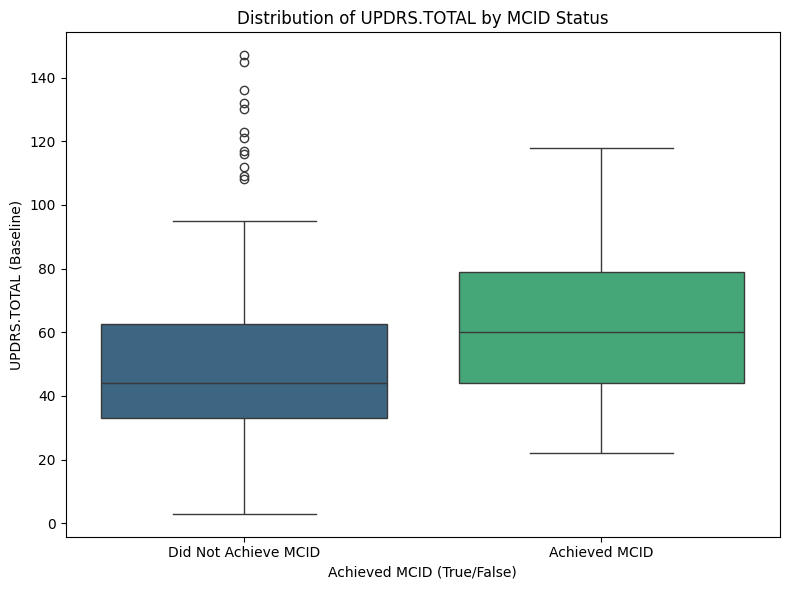

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. Creación de la Variable MCID (Threshold = -3 puntos)
# ---------------------------------------------------------
# Definimos la función lógica
def check_mcid_achievement(delta):
    # Delta es (Final - Inicial).
    # Una reducción de 3 puntos significa un valor de -3 o más negativo (ej. -5).
    if delta <= -3:
        return 'Yes (Improved ≥3 pts)'
    else:
        return 'No'

# Aplicamos la lógica al dataset
df_analysis['MCID_Achieved'] = df_analysis['Delta KPSS.TOTAL'].apply(check_mcid_achievement)

# Verificamos la prevalencia de mejoría clínica
print("Frecuencia de Pacientes que alcanzaron el MCID:")
display(df_analysis['MCID_Achieved'].value_counts())
display(df_analysis['MCID_Achieved'].value_counts(normalize=True) * 100)

# ---------------------------------------------------------
# 2. Visualización: Relación con UPDRS Total
# ---------------------------------------------------------
# Objetivo: Ver si la severidad motora basal (UPDRS) es diferente entre
# los que logran mejorar el dolor y los que no.

if 'UPDRS.TOTAL' in df_analysis.columns:
    plt.figure(figsize=(8, 6))

    # Boxplot comparativo
    sns.boxplot(data=df_analysis.dropna(subset=['UPDRS.TOTAL', 'MCID_Achieved']),
                x='MCID_Achieved',
                y='UPDRS.TOTAL',
                palette='Set2',
                order=['Yes (Improved ≥3 pts)', 'No']) # Orden lógico

    plt.title('Distribución de Severidad Motora (UPDRS) según Logro de MCID', fontsize=14)
    plt.xlabel('¿Alcanzó Diferencia Mínima Clínicamente Importante?', fontsize=12)
    plt.ylabel('Puntaje UPDRS Total (Basal)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ La columna 'UPDRS.TOTAL' no está disponible para graficar.")

**Guía de Interpretación del Gráfico:**

**Comparación de Medianas:** Observa la línea central de las cajas.

Si la caja de "Yes" está más abajo (menor UPDRS) que la de "No", sugiere que los pacientes con Parkinson más leve tienen mayor probabilidad de experimentar una mejoría clínica en el dolor.

Si las cajas están al mismo nivel, la severidad motora no parece influir en la capacidad de mejorar el dolor.

# **Cuantificación del Cambio y Tasa de Éxito Clínico**

Este bloque genera las métricas finales para evaluar la eficacia terapéutica o la evolución natural de la cohorte. Se divide en dos partes: la magnitud del cambio numérico y la prevalencia de pacientes que alcanzaron el umbral de relevancia clínica.

**Ejecución del Reporte Estadístico**

El siguiente código resume la distribución de la variable continua Delta y calcula las frecuencias para la variable dicotómica MCID.

In [ ]:
# 1. Estadística Descriptiva del Cambio Numérico (Delta)
print("Descriptive Statistics for Delta KPSS.TOTAL:")
# .describe() nos da: Media (Tendencia central), Std (Variabilidad), Min/Max (Rango).
# Una media negativa indica que, en promedio, el grupo mejoró.
display(df_analysis['Delta KPSS.TOTAL'].describe())

# 2. Tasa de Éxito (Porcentaje de MCID)
print("\nPercentage of subjects achieving MCID:")
# normalize=True * 100 nos da el % de pacientes que mejoraron vs. no mejoraron.
display(df_analysis['MCID'].value_counts(normalize=True) * 100)

# 3. Conteo Absoluto (Frecuencia)
print("\nCounts of subjects achieving MCID:")
# Nos dice cuántos pacientes (N) representan esos porcentajes.
display(df_analysis['MCID'].value_counts())

Descriptive Statistics for Delta KPSS.TOTAL:


,Delta KPSS.TOTAL
count,260.000000
mean,1.615385
std,10.261737
min,-36.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,74.000000



Percentage of subjects achieving MCID:


,proportion
MCID,
False,88.846154
True,11.153846



Counts of subjects achieving MCID:


,count
MCID,
False,231
True,29


# **Búsqueda de Predictores de Respuesta Clínica (MCID)**

El objetivo de este bloque es identificar variables basales que estén estadísticamente asociadas con la probabilidad de alcanzar una diferencia clínicamente importante. Esto responde a la pregunta: "¿Podemos predecir qué perfil de paciente tiene más probabilidades de mejorar su dolor?"

**Estrategia de Análisis Automatizado**

El código implementa un bucle inteligente que recorre una lista extensa de posibles predictores y selecciona automáticamente la prueba estadística adecuada:

**Variables Categóricas (ej. Sexo, Depresión):** Usa Chi-Cuadrado ($\chi^2$). Compara si la tasa de éxito es diferente entre grupos (ej. ¿Mejoran más los hombres que las mujeres?).

**Variables Numéricas (ej. Edad, UPDRS):** Usa U de Mann-Whitney. Compara si la mediana de la variable es diferente entre los que mejoraron y los que no (ej. ¿Los que mejoraron son significativamente más jóvenes?).

**Reasoning**:
Select relevant explanatory variables and perform appropriate statistical tests (e.g., t-tests, Wilcoxon rank-sum tests, Chi-squared tests) to analyze their association with the dichotomous 'MCID' variable.

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# ---------------------------------------------------------
# 1. Preparación de la Variable Objetivo (Binaria)
# ---------------------------------------------------------
# Aseguramos que la columna MCID sea booleana (True/False) o 1/0 para facilitar el análisis.
# Asumimos que la columna creada antes se llama 'MCID_Achieved' con valor 'Yes (Improved ≥3 pts)'
# Ajusta el string 'Yes...' si tu etiqueta es diferente.
df_analysis['MCID_Binary'] = df_analysis['MCID_Achieved'].astype(str).str.contains('Yes')

print(f"Distribución para análisis (MCID True/False):")
display(df_analysis['MCID_Binary'].value_counts())

# ---------------------------------------------------------
# 2. Definición de Variables Explicativas (Predictores)
# ---------------------------------------------------------
# Lista extensa de factores clínicos, demográficos y no motores
explanatory_vars_list = [
    'Edad', 'Sexo', 'Anios.Escolaridad', 'Tiempo.evolucion.sintomas',
    'Historia.familiar.EP', 'Uso.Levodopa', 'Dosis.Levodopa', 'Hoehn.Yahr',
    'MMSE.Total', 'Escala.Sueno', 'Fatiga', 'Estreñimiento', 'Hiposmia',
    'Dolor', 'Apatia', 'Ansiedad', 'Depresion', 'Alucinaciones.Visuales',
    'Demencia', 'Deterioro.cognitivo.leve', 'Tipo.fenotipico',
    'UPDRS1.Total', 'UPDRS2.Total', 'UPDRS3.Total', 'UPDRS4.Total', 'UPDRS.TOTAL',
    'PDQ8.index', 'PDQ39.SI.index'
]

# Filtro de Seguridad: Solo usar columnas que realmente existen en el dataframe
vars_to_analyze = [col for col in explanatory_vars_list if col in df_analysis.columns]

print(f"\nAnalizando {len(vars_to_analyze)} variables potenciales...")

# ---------------------------------------------------------
# 3. Bucle de Pruebas Estadísticas
# ---------------------------------------------------------

# Separamos los grupos para las pruebas numéricas
group_improved = df_analysis[df_analysis['MCID_Binary'] == True]
group_not_improved = df_analysis[df_analysis['MCID_Binary'] == False]

for var in vars_to_analyze:
    print(f"\n🔹 Analizando: '{var}'")

    # --- Lógica de Selección de Test ---

    # CASO A: Variable Categórica (Texto o pocos valores únicos)
    if df_analysis[var].dtype == 'object' or df_analysis[var].nunique() < 5:
        # Tabla de contingencia (MCID vs Variable)
        contingency_table = pd.crosstab(df_analysis['MCID_Binary'], df_analysis[var]).dropna()

        # Verificar requisitos mínimos (tabla mayor a 1x1 y con datos)
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, p, _, _ = chi2_contingency(contingency_table)

            print(f"   Test: Chi-Cuadrado | P-value: {p:.4f}")
            if p < 0.05:
                print(f"   ✅ ASOCIACIÓN SIGNIFICATIVA (Reject H0)")
            else:
                print(f"   ❌ No significativa")
        else:
            print("   ⚠️ Datos insuficientes para Chi-Cuadrado")

    # CASO B: Variable Numérica
    else:
        # Obtenemos los datos limpios de NaNs para cada grupo
        vals_improved = group_improved[var].dropna()
        vals_not_improved = group_not_improved[var].dropna()

        if len(vals_improved) > 0 and len(vals_not_improved) > 0:
            # Mann-Whitney U (No paramétrico, más seguro que T-test para datos clínicos)
            stat, p = mannwhitneyu(vals_improved, vals_not_improved)

            print(f"   Test: Mann-Whitney U | P-value: {p:.4f}")
            if p < 0.05:
                print(f"   ✅ DIFERENCIA SIGNIFICATIVA (Reject H0)")
                print(f"      - Media en Mejoría: {vals_improved.mean():.2f}")
                print(f"      - Media en NO Mejoría: {vals_not_improved.mean():.2f}")
            else:
                print(f"   ❌ No significativa")
        else:
            print("   ⚠️ Datos insuficientes para Mann-Whitney")

Analyzing associations with the following explanatory variables and MCID: ['UPDRS.TOTAL', 'PDQ8.index', 'PDQ39.mov.index', 'PDQ39.daily.index', 'PDQ39.Emotion.index', 'PDQ39.stigma.index', 'PDQ39.social.index', 'PDQ39.cogni.index', 'PDQ39.comm.index', 'PDQ39.discom.index', 'PDQ39.SI.index']

Analyzing association between 'UPDRS.TOTAL' and 'MCID'
  Mann-Whitney U test statistic: 3095.0000
  P-value: 0.0100
  Result: Statistically significant difference in 'UPDRS.TOTAL' between MCID groups (reject H0)
    Mean of 'UPDRS.TOTAL' for MCID=True: 61.92
    Mean of 'UPDRS.TOTAL' for MCID=False: 48.48

Analyzing association between 'PDQ8.index' and 'MCID'
  Mann-Whitney U test statistic: 2751.5000
  P-value: 0.1593
  Result: No statistically significant difference in 'PDQ8.index' between MCID groups (fail to reject H0)

Analyzing association between 'PDQ39.mov.index' and 'MCID'
  Mann-Whitney U test statistic: 2313.5000
  P-value: 0.9292
  Result: No statistically significant difference in 'PDQ

**Reasoning**:
Define the 'MCID' variable based on the calculated 'Delta KPSS.TOTAL' column, where MCID is true if the reduction is 3 or more points.

In [ ]:
# Define the MCID variable: True if Delta KPSS.TOTAL is <= -3, False otherwise
df_analysis['MCID'] = (df_analysis['Delta KPSS.TOTAL'] <= -3)

# Display the distribution of the new MCID variable
print("Distribution of MCID:")
display(df_analysis['MCID'].value_counts())

# Display the head of the df_analysis dataframe with the new MCID column to verify
# Displaying only columns that are present in df_analysis
columns_to_display = ['reg.innn', 'Delta KPSS.TOTAL', 'MCID']
display(df_analysis[columns_to_display].head())

Distribution of MCID:


,count
MCID,
False,231
True,29


,reg.innn,Delta KPSS.TOTAL,MCID
0,104248,-8,True
1,113193,-1,False
2,129131,0,False
3,133232,10,False
4,143927,0,False


**Guía de Interpretación de Resultados:**

Si encuentras ✅ ASOCIACIÓN SIGNIFICATIVA:

Esa variable es un candidato fuerte para ser un predictor.

Ejemplo: Si en Dosis.Levodopa sale significativo y la media es más alta en el grupo de mejoría, sugiere que "A mayor dosis basal, mayor probabilidad de reducir el dolor".

Mann-Whitney U vs. T-Test:

Hemos priorizado Mann-Whitney porque variables como el estadio Hoehn & Yahr o escalas de sueño no suelen tener una distribución normal perfecta. Es una apuesta más segura y robusta.

# Data Table for Each Subject and Visit

### Subtask:
Display the data for each unique subject and their visits in a table format.

**Reasoning**:
Display the `df_filtered` DataFrame, which contains all visits for each subject with more than one visit, to show the data in a table format.

In [ ]:
# Display the df_filtered DataFrame as a table
display(df_filtered)

,Consecutivo,anio.eval_kpps,fecha.eval_kpps,accum.visits_kpps,visit.numb,reg.innn,KPSS1.F,KPSS1.S,KPSS1.TOT,KPSS.D1,...,PDQ8.index,PDQ39.mov.index,PDQ39.daily.index,PDQ39.Emotion.index,PDQ39.stigma.index,PDQ39.social.index,PDQ39.cogni.index,PDQ39.comm.index,PDQ39.discom.index,PDQ39.SI.index
3,4537,2023,8/14/2023,10,9,104248,1,1,1,1,...,31.250,37.5,29.166667,41.666667,31.25,50.000000,31.25,50.000000,33.333333,38.020833
4,4538,2024,2024-02-12 00:00:00,10,10,104248,1,0,0,0,...,25.000,80.0,62.500000,8.333333,18.75,0.000000,6.25,0.000000,0.000000,21.979167
5,4362,2022,2022-03-03 00:00:00,3,2,113193,2,2,4,4,...,18.750,7.5,0.000000,25.000000,0.00,0.000000,18.75,0.000000,25.000000,9.531250
6,4363,2024,2/15/2024,3,3,113193,1,1,1,1,...,31.250,30.0,12.500000,25.000000,18.75,0.000000,18.75,0.000000,33.333333,17.291667
7,4555,2021,10/18/2021,3,2,129131,0,0,0,0,...,6.250,22.5,12.500000,0.000000,0.00,0.000000,12.50,0.000000,0.000000,5.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,4150,2024,10/14/2024,2,2,299898,0,0,0,0,...,18.750,15.0,8.333333,4.166667,6.25,0.000000,25.00,0.000000,8.333333,8.385417
1043,4297,2024,2024-01-02 00:00:00,2,1,302321,2,1,2,2,...,28.125,25.0,70.833333,20.833333,50.00,16.666667,12.50,16.666667,33.333333,30.729167
1044,4286,2024,8/19/2024,2,2,302321,2,2,4,4,...,6.250,10.0,4.166667,12.500000,12.50,16.666667,0.00,0.000000,16.666667,9.062500
1048,4458,2024,3/21/2024,2,1,303536,2,2,4,4,...,0.000,17.5,8.333333,8.333333,6.25,0.000000,12.50,8.333333,16.666667,9.739583
